<a href="https://colab.research.google.com/github/Farzana2800/NVIDIAGTC2026/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:
# Large dataset for GPU advantage
n = 300_000
time = np.arange(n)

np.random.seed(42)

# Simulated building variables
outdoor_temp = 30 + 10*np.sin(time/5000)
occupancy = np.clip(50 + 40*np.sin(time/2000), 0, 100)
supply_temp = 55 + np.random.normal(0, 1, n)
return_temp = supply_temp + np.random.normal(15, 2, n)
airflow = 5000 + occupancy*10 + np.random.normal(0, 200, n)
energy = 200 + 0.5*outdoor_temp + 0.01*airflow + np.random.normal(0, 5, n)

df = pd.DataFrame({
    "outdoor_temp": outdoor_temp,
    "occupancy": occupancy,
    "supply_temp": supply_temp,
    "return_temp": return_temp,
    "airflow": airflow,
    "energy": energy
})

# Inject faults
df.loc[200000:220000, "energy"] += np.linspace(0,50,20001)  # coil fouling
df.loc[120000:130000, "airflow"] -= 2000  # damper stuck
df.loc[250000:260000, "supply_temp"] += 5  # sensor bias

# Convert to numpy array for PyTorch
data = df.values.astype(np.float32)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

input_dim = data.shape[1]
model = Autoencoder(input_dim).to(device)

In [4]:
from torch.utils.data import DataLoader, TensorDataset

tensor_data = torch.tensor(data).to(device)
dataset = TensorDataset(tensor_data)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [5]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for batch in loader:
        x = batch[0]
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 949161.2611
Epoch 2, Loss: 253.6192
Epoch 3, Loss: 251.9586
Epoch 4, Loss: 250.0430
Epoch 5, Loss: 247.7486


In [6]:
with torch.no_grad():
    reconstructed = model(tensor_data).cpu().numpy()

reconstruction_error = np.mean((data - reconstructed)**2, axis=1)

# Mark anomalies (top 2% reconstruction error)
threshold = np.percentile(reconstruction_error, 98)
anomalies = reconstruction_error > threshold

df['anomaly'] = anomalies

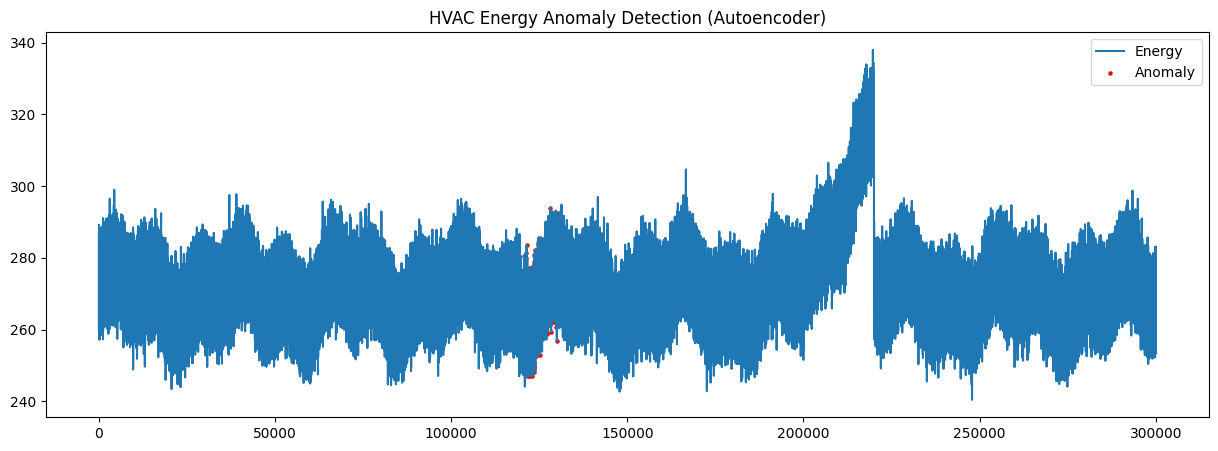

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df['energy'], label='Energy')
plt.scatter(df.index[df['anomaly']], df['energy'][df['anomaly']], color='red', s=5, label='Anomaly')
plt.legend()
plt.title('HVAC Energy Anomaly Detection (Autoencoder)')
plt.show()

In [8]:
waste_estimate = df[df['anomaly']]['energy'].mean() - df[~df['anomaly']]['energy'].mean()
print("Estimated Excess Energy During Fault (kW):", waste_estimate)

Estimated Excess Energy During Fault (kW): -3.02396391541879
